# Continuos Regression with *KQM*

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$, and we will actually do the inference over $\theta$. Therefore, the range of the output variable must be within $[0, \pi/2]$.

### Import libraries

In [1]:
import re

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm
import itertools
print("Tensorflow version:",tf.__version__)

2024-11-08 14:35:10.547011: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 14:35:10.570399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 14:35:10.570420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 14:35:10.571119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 14:35:10.575450: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: 2.15.0


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-11-08 14:35:11.510190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-11-08 14:35:11.533573: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 14:35:11.533723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


### Check GPU

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov  8 14:35:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8               4W /  40W |      9MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Loading Dataset

## Boston

In [7]:
data = pd.read_csv('/home/santiagotoco/Documents/Quantum_Regression/datasets/housing', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1].reshape(-1, 1)
X = X[:,0:-1]

## 70% - 30% Hold Out and MinMax Scaling for `y` 

In [8]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

scaler = MinMaxScaler(feature_range=(0.2, np.pi/2-0.2))
scaler.fit(y_train)
y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test))
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

print(f"Training features size: {X_train.shape}")
print(f"Training labels size: {y_train.shape}")

Training set size: (354, 13)
Test set size: (152, 13)
Training features size: (354, 13)
Training labels size: (354,)


## Defining KQM-Model

In [9]:
n_comp=32

In [10]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

## Training and Test

2024-11-08 14:39:16.867040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 14:39:16.867276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 14:39:16.867435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

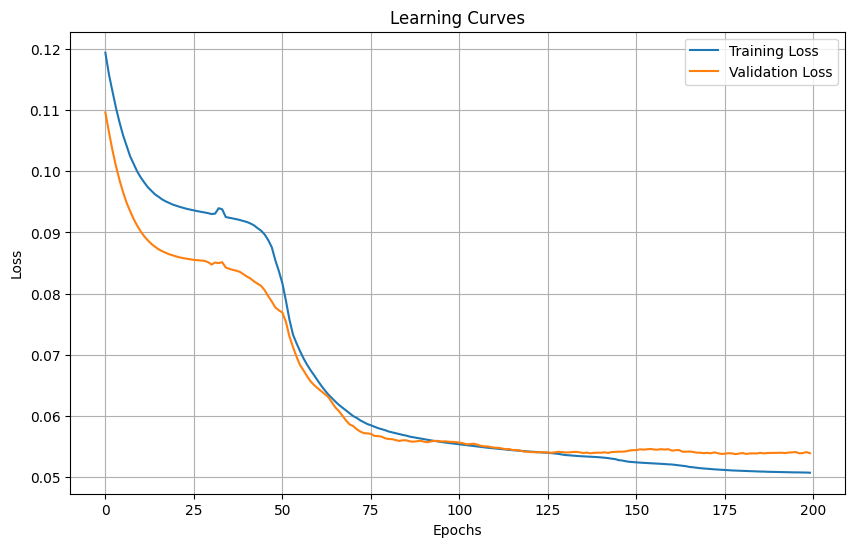

MAE = 0.49470699696164383
MSE = 0.5147942413522917
R^2 = 0.4731425846200067


In [11]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=50,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = X_train.shape[1]
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

# Initializing weights `c_y`

ok


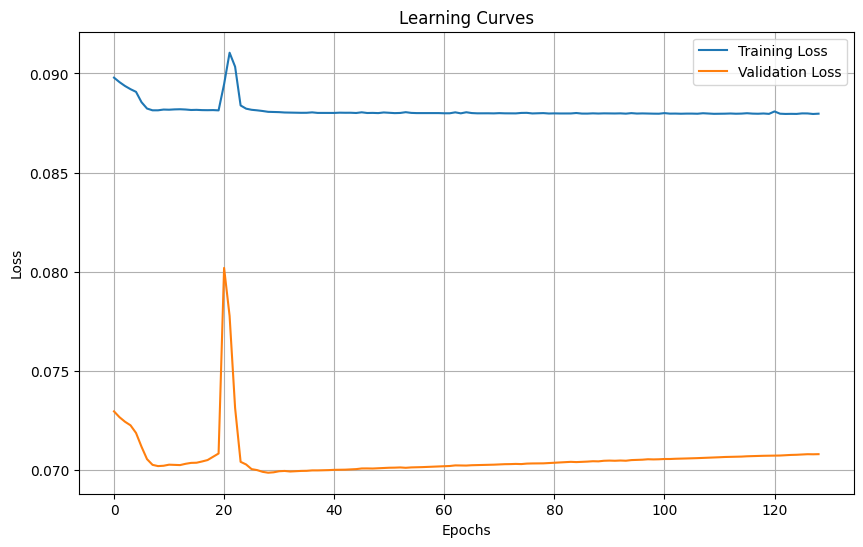

MAE = 0.8025134794021908
MSE = 0.9725010283185502
R^2 = 0.004710354007894324


In [12]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = X_train.shape[1]
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
selected_labels = y_train[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))
print('ok')

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

In [15]:
y_pred

array([2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 1.9980763,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       1.9450583, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 1.893111 , 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 1.943675 , 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.2506535, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 2.4603572, 2.4650018,
       2.4650018, 2.4650018, 2.4650018, 2.4650018, 

In [16]:
y_test

array([2., 4., 4., 2., 3., 2., 1., 2., 3., 5., 3., 1., 2., 2., 1., 3., 2.,
       2., 3., 3., 4., 4., 1., 5., 2., 3., 2., 3., 3., 5., 2., 1., 2., 2.,
       3., 2., 1., 2., 3., 2., 5., 1., 3., 2., 2., 2., 1., 2., 3., 1., 1.,
       5., 1., 2., 4., 4., 3., 5., 2., 3., 2., 2., 3., 1., 2., 3., 2., 2.,
       1., 3., 2., 4., 3., 2., 2., 2., 2., 3., 2., 4., 2., 2., 3., 2., 1.,
       3., 3., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2.,
       3., 1., 2., 2., 1., 1., 2., 2., 3., 2., 2., 2., 3., 3., 2., 1., 4.,
       3., 3., 3., 2., 2., 1., 1., 2., 2., 2., 4., 2., 1., 1., 2., 2., 3.,
       2., 2., 3., 1., 1., 5., 2., 3., 2., 2., 2., 3., 1., 3., 3., 3.])

# Hyper-parameter exploration

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
```

In [17]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']

# Some fixed hyper-params
encoding_dim = X_train.shape[1]
num_hidden_layer = 1
n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [18]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [19]:
best_MSE = 1000

for lr, kernel in itertools.product(learning_rates, kernels):
    print(f"Running experiment with learning_rate={lr} and kernel={kernel}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05 and kernel=rbf
MAE = 0.9469354529129831
MSE = 1.311553942160874
R^2 = -0.34228758713997043
New best model
Running experiment with learning_rate=1e-05 and kernel=cos
MAE = 0.9427631262101626
MSE = 1.2983208104345072
R^2 = -0.32874436342320523
New best model
Running experiment with learning_rate=5e-05 and kernel=rbf
MAE = 0.8828947763693961
MSE = 1.0972654144639358
R^2 = -0.1229776361362025
New best model
Running experiment with learning_rate=5e-05 and kernel=cos
MAE = 0.811205140854183
MSE = 0.9333780740239269
R^2 = 0.04475007653382912
New best model
Running experiment with learning_rate=0.0001 and kernel=rbf
MAE = 0.8389734986581301
MSE = 1.0124032392655316
R^2 = -0.03612688549239618
Running experiment with learning_rate=0.0001 and kernel=cos
MAE = 0.7085759200547871
MSE = 0.7872910079168678
R^2 = 0.19426040102275455
New best model
Running experiment with learning_rate=0.0005 and kernel=rbf
MAE = 0.5351235239129317
MSE = 0.5304782941604999
R^

```
Running experiment with learning_rate=0.1 and kernel=rbf
MAE = 0.3600476015555231
MSE = 0.2535346134240543
R^2 = 0.7405243096988106
New best model
```

## Adding an Encoder

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layer = [1,2]
```

In [20]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [16, 32, 64]
num_hidden_layers = [1,2]

# Some fixed hyper-params

n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [21]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [22]:
best_MSE = 1000

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.9476061996660734
MSE = 1.3135621285755046
R^2 = -0.34434283138907906
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.9483895301818848
MSE = 1.3189580383697903
R^2 = -0.3498651835435498
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.9459684851922487
MSE = 1.3073742411215217
R^2 = -0.33800994316153443
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.9441921287461331
MSE = 1.3031869974405723
R^2 = -0.3337245797947723
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.9454734231296339
MSE = 1.3053583687893482
R^2 = -0.33594683289076865
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.9450647956446597
MSE = 1.3037259862934358


```
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.29342561332803024
MSE = 0.17932416354320999
R^2 = 0.8164737331338949
New best model
```

In [27]:
y_test.max(), y_test.mean(), y_test.min()

(310.0, 148.02255639097746, 37.0)

# Analysis

In [23]:
texto = """
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.9476061996660734
MSE = 1.3135621285755046
R^2 = -0.34434283138907906
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.9483895301818848
MSE = 1.3189580383697903
R^2 = -0.3498651835435498
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.9459684851922487
MSE = 1.3073742411215217
R^2 = -0.33800994316153443
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.9441921287461331
MSE = 1.3031869974405723
R^2 = -0.3337245797947723
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.9454734231296339
MSE = 1.3053583687893482
R^2 = -0.33594683289076865
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.9450647956446597
MSE = 1.3037259862934358
R^2 = -0.3342761987740219
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.9354285221350821
MSE = 1.288478391091679
R^2 = -0.3186713066570168
New best model
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.9359946956760005
MSE = 1.282646907560407
R^2 = -0.3127031739656987
New best model
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.9222519821242282
MSE = 1.2590357323143717
R^2 = -0.28853871802397535
New best model
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.9195105182497125
MSE = 1.2459370808383237
R^2 = -0.27513312583338356
New best model
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.9212783684856013
MSE = 1.2544692188881923
R^2 = -0.28386519748362327
Running experiment with learning_rate=1e-05, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.9132717173350485
MSE = 1.233931570494077
R^2 = -0.26284629035194484
New best model
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.8475891947746277
MSE = 1.0106294826288642
R^2 = -0.034311564414497564
New best model
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.8178269157284185
MSE = 0.9621941458851118
R^2 = 0.015258757628809683
New best model
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.8790707227430845
MSE = 1.0879536796999687
R^2 = -0.11344769948119926
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.8770017827811994
MSE = 1.0835119965801863
R^2 = -0.1089019343959523
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.8764146833043349
MSE = 1.0814927297408494
R^2 = -0.10683535007453315
Running experiment with learning_rate=5e-05, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.8757627198570653
MSE = 1.0799426845465316
R^2 = -0.10524898266946026
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.693286762425774
MSE = 0.7021306906851554
R^2 = 0.2814162800624659
New best model
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.6924225264473965
MSE = 0.6796953661680181
R^2 = 0.3043773315638587
New best model
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.6862106103646127
MSE = 0.6697904453128064
R^2 = 0.3145143544404394
New best model
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.6644453814155177
MSE = 0.6492607303896286
R^2 = 0.33552514219614715
New best model
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.6405701762751529
MSE = 0.5979534253488519
R^2 = 0.3880347313727631
New best model
Running experiment with learning_rate=5e-05, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.6392717894754911
MSE = 0.5993928693601903
R^2 = 0.38656155686831284
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.6759585048023024
MSE = 0.7164699100119909
R^2 = 0.2667410497932652
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.5200613611622861
MSE = 0.4777734357222519
R^2 = 0.5110308988293728
New best model
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.8348121815606168
MSE = 1.0069656633195685
R^2 = -0.030561890823269433
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.8321469222244463
MSE = 1.0038080226021358
R^2 = -0.02733025710740833
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.8319396658947593
MSE = 1.0033910874421224
R^2 = -0.02690355190532867
Running experiment with learning_rate=0.0001, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.8316739719164999
MSE = 1.0032813037510697
R^2 = -0.026791195652922095
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.46876487449595805
MSE = 0.41603561653348764
R^2 = 0.5742154204035571
New best model
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.4391873776912689
MSE = 0.4173623067635148
R^2 = 0.5728576418399005
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.42959095772944
MSE = 0.3691849073924011
R^2 = 0.6221639822638301
New best model
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.4412795509162702
MSE = 0.37747857267607915
R^2 = 0.6136759715123751
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.42684483528137207
MSE = 0.3686226169478422
R^2 = 0.6227394488609991
New best model
Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.4222992140995829
MSE = 0.35911286544470233
R^2 = 0.6324720423816432
New best model
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.49927836499716105
MSE = 0.40241616257010177
R^2 = 0.5881540190467495
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.379438150085901
MSE = 0.27405318742234147
R^2 = 0.7195249239332989
New best model
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.5718317722019396
MSE = 0.544964026653236
R^2 = 0.4422658307066949
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.37165676998464686
MSE = 0.259771815617702
R^2 = 0.7341409511392519
New best model
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.8141619218023199
MSE = 0.9866696538792296
R^2 = -0.009790284971239016
Running experiment with learning_rate=0.0005, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.3407187799089833
MSE = 0.22310547407181644
R^2 = 0.7716664951071873
New best model
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.3732895647224627
MSE = 0.2165005914257213
R^2 = 0.7784261499756427
New best model
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.3615194261074066
MSE = 0.22934087904320938
R^2 = 0.7652849758841944
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.3621996484304729
MSE = 0.23916578246402165
R^2 = 0.755229845490642
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.3336555651928249
MSE = 0.21456614509344346
R^2 = 0.780405926190967
New best model
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.3960973996865122
MSE = 0.2686097451125072
R^2 = 0.7250959224328077
Running experiment with learning_rate=0.0005, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.3059431988941996
MSE = 0.20575838476042263
R^2 = 0.7894200787816255
New best model
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.4478196838968678
MSE = 0.3840349439017523
R^2 = 0.6069659648325101
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.3285013507855566
MSE = 0.23991917404231447
R^2 = 0.7544587996866607
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.48965291208342504
MSE = 0.38396542823694774
R^2 = 0.607037109457965
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.8136758020049647
MSE = 0.9863286086618958
R^2 = -0.009441248040949812
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.8130095695194445
MSE = 0.9858712578782639
R^2 = -0.008973180155898541
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.8132040437899137
MSE = 0.9860035576354412
R^2 = -0.009108580093432295
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.34300907897321803
MSE = 0.2359952425259982
R^2 = 0.7584746806945443
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.3412380783181441
MSE = 0.23904342251793018
R^2 = 0.7553550726974858
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.3792115245994769
MSE = 0.24616506998232338
R^2 = 0.7480665436601728
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.3243977874517441
MSE = 0.20128419001342096
R^2 = 0.7939991173390885
New best model
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.3245188217414053
MSE = 0.1908366595458934
R^2 = 0.8046914647996314
New best model
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.3109276161382073
MSE = 0.18890976205422802
R^2 = 0.8066635152823529
New best model
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.3438773523820074
MSE = 0.2561214606504492
R^2 = 0.7378768448784948
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.3181457613643847
MSE = 0.24682969621460005
R^2 = 0.7473863432406591
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.8116512800517836
MSE = 0.984974845143274
R^2 = -0.008055761780296988
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.5155549221917203
MSE = 0.489674828890284
R^2 = 0.4988506203020544
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.8113627967081571
MSE = 0.9847906807080867
R^2 = -0.007867281819696093
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.5257062802189275
MSE = 0.4704158343258342
R^2 = 0.5185609109074607
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.29342561332803024
MSE = 0.17932416354320999
R^2 = 0.8164737331338949
New best model
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.38233722432663564
MSE = 0.3193778998438699
R^2 = 0.6731381174754033
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.3380444724308817
MSE = 0.22722042259546976
R^2 = 0.7674551209902223
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.2954242664732431
MSE = 0.2100543440632499
R^2 = 0.7850234522596976
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.32741798538910716
MSE = 0.23431687482534552
R^2 = 0.760192377587385
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.3202499598264694
MSE = 0.23283352549769978
R^2 = 0.7617104862414682
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.8114684004532663
MSE = 0.9848578439703392
R^2 = -0.007936018918747179
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.8115057537430211
MSE = 0.9848816703476533
R^2 = -0.007960403619587275
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.811617418339378
MSE = 0.9849531152914025
R^2 = -0.00803352273278235
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.5029628167026922
MSE = 0.4795758139059333
R^2 = 0.5091862855157172
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.811596995905826
MSE = 0.9849400242588002
R^2 = -0.008020124937998752
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.8115730160161069
MSE = 0.9849246667985139
R^2 = -0.008004407606328368
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.3367131854358472
MSE = 0.24078520348628896
R^2 = 0.7535724765737666
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.30394181373872253
MSE = 0.23289411544179314
R^2 = 0.7616484764931478
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.3279951606926165
MSE = 0.254415384826434
R^2 = 0.7396228991791836
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.34008858705821793
MSE = 0.2307752618686926
R^2 = 0.7638169811643732
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.31505657418778066
MSE = 0.22336199389533098
R^2 = 0.7714039642543642
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.3126399101395356
MSE = 0.2475823686686733
R^2 = 0.7466160334121361
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.8109803042913738
MSE = 0.9845498633511894
R^2 = -0.007620821389407784
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.8119321214525324
MSE = 0.9851562252100172
R^2 = -0.008241392126344893
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.8119464830348366
MSE = 0.9851655560967623
R^2 = -0.008250941663769495
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.8113167474144384
MSE = 0.9847614851377162
R^2 = -0.007837402109492686
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 0.8113291985110233
MSE = 0.9847693737398381
R^2 = -0.007845475565236626
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 0.811503645620848
MSE = 0.9848803246759507
R^2 = -0.007959026414758208
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 0.4158983430580089
MSE = 0.2988267451317117
R^2 = 0.6941708474186903
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 0.4896152968469419
MSE = 0.3626912387093063
R^2 = 0.628809817092367
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 0.41040631971861186
MSE = 0.31539660424060684
R^2 = 0.6772127067829466
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.47289978908865077
MSE = 0.35593028406381927
R^2 = 0.635729201195549
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 0.43892022418348414
MSE = 0.31754431790406734
R^2 = 0.6750146657428318
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 0.5528047147550081
MSE = 0.5396184963193835
R^2 = 0.44773662285878024
"""

In [24]:
# Expresión regular para extraer los datos
pattern = re.compile(
    r"Running experiment with learning_rate=(?P<learning_rate>[\deE\-\+\.]+), "
    r"kernel=(?P<kernel>\w+), "
    r"encoding_dim=(?P<encoding_dim>\d+) and num_h_l=(?P<num_h_l>\d+)\n"
    r"MAE = (?P<MAE>[\d\.\-eE]+)\n"
    r"MSE = (?P<MSE>[\d\.\-eE]+)\n"
    r"R\^2 = (?P<R2>[\d\.\-eE]+)"
)

# Extraer los datos en un diccionario
datos = [m.groupdict() for m in pattern.finditer(texto)]

# Convertir a DataFrame
df_resultados = pd.DataFrame(datos)

# Convertir columnas numéricas al tipo adecuado
df_resultados['learning_rate'] = df_resultados['learning_rate'].astype(float)
df_resultados['encoding_dim'] = df_resultados['encoding_dim'].astype(int)
df_resultados['num_h_l'] = df_resultados['num_h_l'].astype(int)
df_resultados['MAE'] = df_resultados['MAE'].astype(float)
df_resultados['MSE'] = df_resultados['MSE'].astype(float)
df_resultados['R2'] = df_resultados['R2'].astype(float)

# Mostrar el DataFrame
print(df_resultados)

    learning_rate kernel  encoding_dim  num_h_l       MAE       MSE        R2
0         0.00001    rbf            16        1  0.947606  1.313562 -0.344343
1         0.00001    rbf            16        2  0.948390  1.318958 -0.349865
2         0.00001    rbf            32        1  0.945968  1.307374 -0.338010
3         0.00001    rbf            32        2  0.944192  1.303187 -0.333725
4         0.00001    rbf            64        1  0.945473  1.305358 -0.335947
..            ...    ...           ...      ...       ...       ...       ...
91        0.10000    cos            16        2  0.489615  0.362691  0.628810
92        0.10000    cos            32        1  0.410406  0.315397  0.677213
93        0.10000    cos            32        2  0.472900  0.355930  0.635729
94        0.10000    cos            64        1  0.438920  0.317544  0.675015
95        0.10000    cos            64        2  0.552805  0.539618  0.447737

[96 rows x 7 columns]


In [25]:
df_resultados

,learning_rate,kernel,encoding_dim,num_h_l,MAE,MSE,R2
0,0.00001,rbf,16,1,0.947606,1.313562,-0.344343
1,0.00001,rbf,16,2,0.948390,1.318958,-0.349865
2,0.00001,rbf,32,1,0.945968,1.307374,-0.338010
3,0.00001,rbf,32,2,0.944192,1.303187,-0.333725
4,0.00001,rbf,64,1,0.945473,1.305358,-0.335947
...,...,...,...,...,...,...,...
91,0.10000,cos,16,2,0.489615,0.362691,0.628810
92,0.10000,cos,32,1,0.410406,0.315397,0.677213
93,0.10000,cos,32,2,0.472900,0.355930,0.635729
94,0.10000,cos,64,1,0.438920,0.317544,0.675015


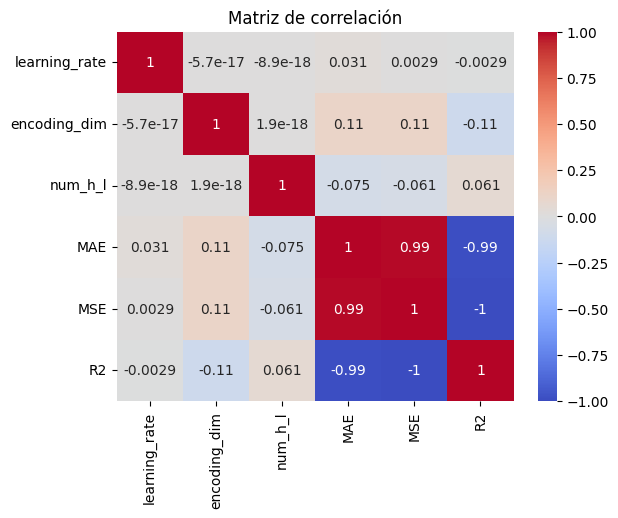

MAE              1.000000
MSE              0.990971
encoding_dim     0.109904
learning_rate    0.030935
num_h_l         -0.075330
R2              -0.990971
Name: MAE, dtype: float64


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la correlación entre las columnas
correlation_matrix = df_resultados.corr()

# Visualizar la correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

# Correlación específica con MAE
print(correlation_matrix['MAE'].sort_values(ascending=False))


In [27]:
from sklearn.linear_model import LinearRegression

# Variables independientes y dependiente
X = df_resultados[['learning_rate', 'encoding_dim', 'num_h_l']]
y = df_resultados['MAE']

# Ajustar el modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Coeficientes del modelo
coeficientes = pd.Series(modelo.coef_, index=X.columns)
print("Impacto de las variables en el MAE:")
print(coeficientes.sort_values(ascending=False))


Impacto de las variables en el MAE:
learning_rate    0.222505
encoding_dim     0.001286
num_h_l         -0.035166
dtype: float64


Importancia de las características según Random Forest:
learning_rate    0.791428
encoding_dim     0.125314
num_h_l          0.083258
dtype: float64


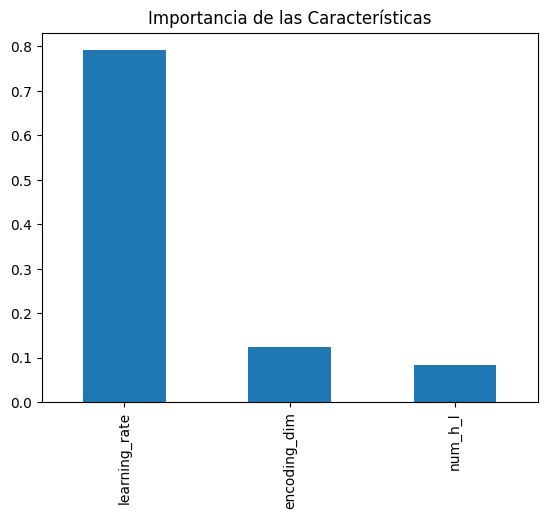

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Crear y ajustar un modelo Random Forest
modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X, y)

# Importancia de las características
importancias = pd.Series(modelo_rf.feature_importances_, index=X.columns)
print("Importancia de las características según Random Forest:")
print(importancias.sort_values(ascending=False))

# Visualizar las importancias
importancias.sort_values(ascending=False).plot(kind='bar')
plt.title("Importancia de las Características")
plt.show()


In [29]:
# Crear una nueva interacción manual
df_resultados['dim_hl_interaction'] = df_resultados['encoding_dim'] * df_resultados['num_h_l']

# Evaluar con regresión o modelo de árbol
X = df_resultados[['learning_rate', 'encoding_dim', 'num_h_l', 'dim_hl_interaction']]
modelo_rf.fit(X, y)

# Recalcular las importancias
importancias_interaccion = pd.Series(modelo_rf.feature_importances_, index=X.columns)
print("Importancia con interacciones:")
print(importancias_interaccion.sort_values(ascending=False))


Importancia con interacciones:
learning_rate         0.790421
encoding_dim          0.082327
dim_hl_interaction    0.074687
num_h_l               0.052565
dtype: float64


In [30]:
df_resultados.describe()

,learning_rate,encoding_dim,num_h_l,MAE,MSE,R2,dim_hl_interaction
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.014582,37.333333,1.500000,0.602476,0.648360,0.336447,56.000000
std,0.032622,20.060260,0.502625,0.234639,0.394098,0.403333,36.853051
min,0.000010,16.000000,1.000000,0.293426,0.179324,-0.349865,16.000000
25%,0.000087,16.000000,1.000000,0.369292,0.252707,-0.009007,32.000000
50%,0.000750,32.000000,1.500000,0.539255,0.514647,0.473294,48.000000
75%,0.006250,64.000000,2.000000,0.813322,0.985904,0.741371,64.000000
max,0.100000,64.000000,2.000000,0.948390,1.318958,0.816474,128.000000


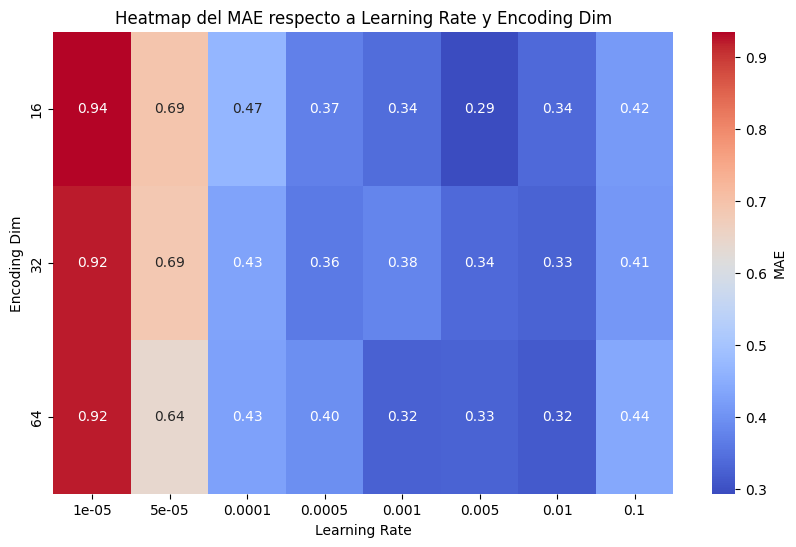

In [31]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'cos') & (df_resultados['num_h_l'] == 1)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

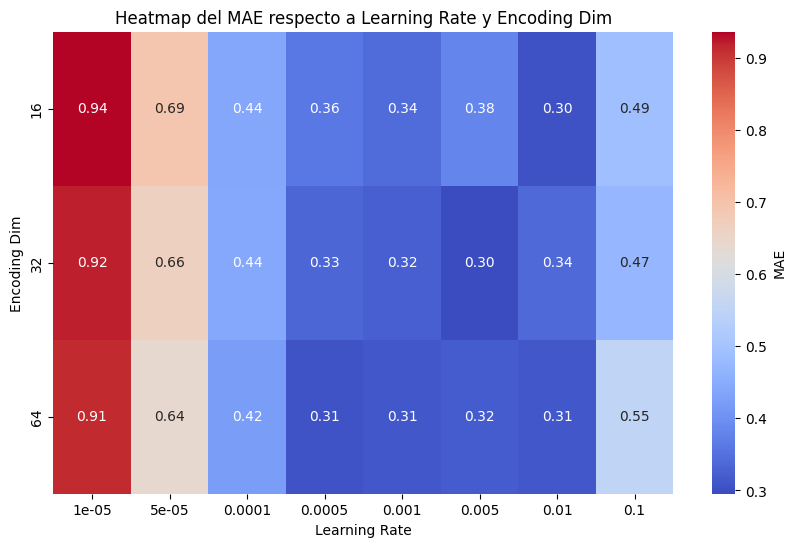

In [32]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'cos') & (df_resultados['num_h_l'] == 2)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

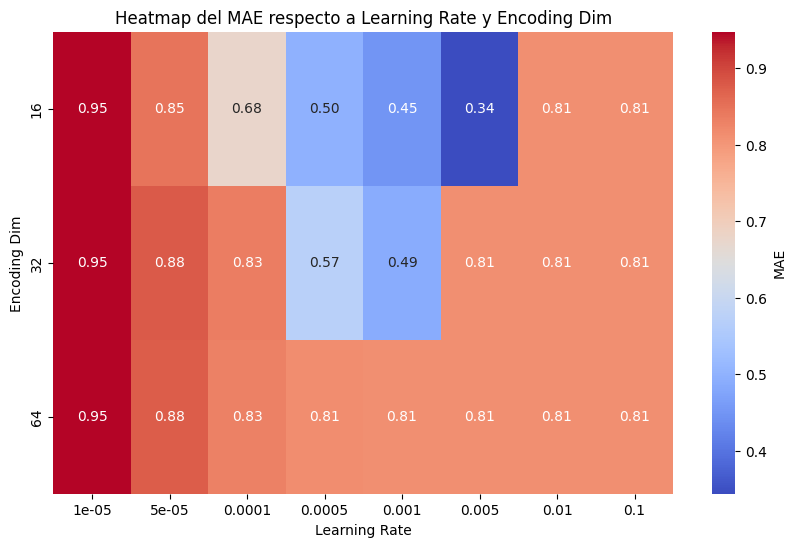

In [33]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'rbf') & (df_resultados['num_h_l'] == 1)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

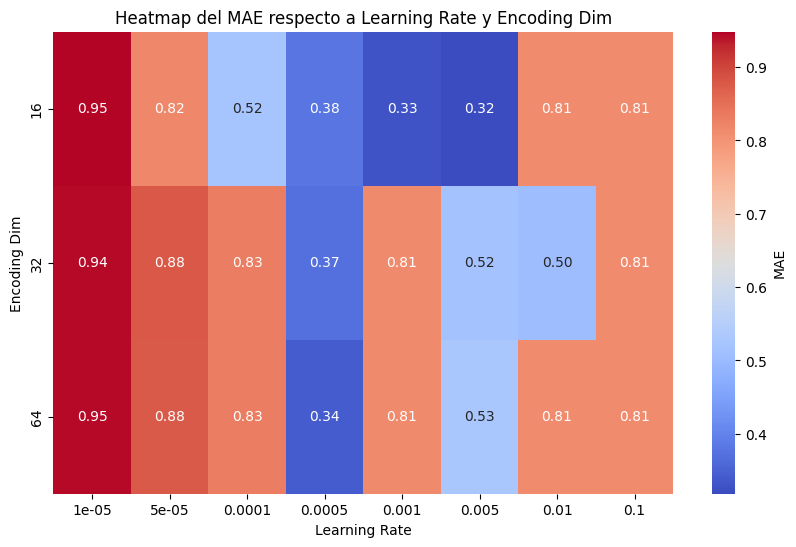

In [34]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'rbf') & (df_resultados['num_h_l'] == 2)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()